<a href="https://colab.research.google.com/github/rajeshmore1/Fuzzy-Text-Matching/blob/main/Rajesh_More_Document_Data_Fuzzy_Text_Match.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML: R-Programing: Fuzzy Text Match (Solved in Python 3)
Read excel file. (DocumentData.xlsx)

Create test/training sample set

Predict Best Match of Test data docs from Training data docs

Output Matched docs, Count of Matched docs and Confidence score.


In [ ]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from gensim.models.doc2vec import LabeledSentence
import gensim
from scipy import stats 
from sklearn import metrics 
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split

import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
pip install fuzzywuzzy


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Xeeva/Assignment-2/Data/Copy of DocumentsData.xlsx')
df = df.rename(columns={'Doc Name': 'DocName'})

In [ ]:
df.sample(5)

,Id,DocName
416,417,"11/64"" Cobalt 135Â° Split Point Gold Finish Jobber Drill"
250,251,Tape; 50 ft.; 1? 2 in.; Black on Clear
413,414,"1/2"" Cobalt 135Â° Split Point Gold Finish Jobber Drill"
451,452,"3/8""-16 x 1-1/4"" ASTM A574 Hex Drive Black Oxide Finish Alloy Steel Socket Cap Screw"
393,394,#56 Cobalt 135° Split Point Gold Finish Jobber Drill


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       500 non-null    int64 
 1   DocName  500 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


In [ ]:
df.shape

(500, 2)

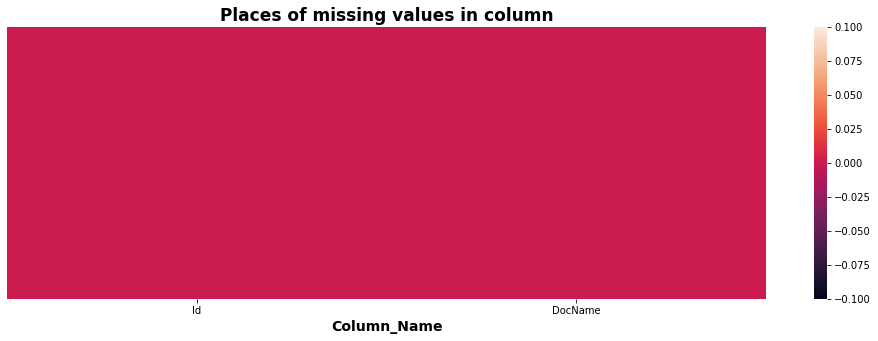

In [ ]:
plt.figure(figsize=(17, 5))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False)
plt.xlabel("Column_Name", size=14, weight="bold")
plt.title("Places of missing values in column",fontweight="bold",size=17)
plt.show()

In [ ]:
from fuzzywuzzy import fuzz


In [ ]:
# checkig fuzz ratio for 12th and 13th id
fuzz.ratio("3M 2 Diam Aluminum Oxide Quick Change Disc Type R Attaching System, Brown, Coarse Grade, 25,000 Max RPM", "3M 3 Diam Aluminum Oxide Quick Change Disc Type R Attaching System, Blue, Very Fine Grade, 18,000 Max RPM")

88

In [ ]:
# checkig partial ratio for 12th and 13th id

fuzz.partial_ratio("3M 2 Diam Aluminum Oxide Quick Change Disc Type R Attaching System, Brown, Coarse Grade, 25,000 Max RPM", "3M 3 Diam Aluminum Oxide Quick Change Disc Type R Attaching System, Blue, Very Fine Grade, 18,000 Max RPM")

87

In [ ]:
# checkig token_sort_ratio for 12th and 13th id
fuzz.token_sort_ratio("3M 2 Diam Aluminum Oxide Quick Change Disc Type R Attaching System, Brown, Coarse Grade, 25,000 Max RPM", "3M 3 Diam Aluminum Oxide Quick Change Disc Type R Attaching System, Blue, Very Fine Grade, 18,000 Max RPM")

85

In [ ]:
# checkig token_set_ratio for 12th and 13th id
fuzz.token_set_ratio("3M 2 Diam Aluminum Oxide Quick Change Disc Type R Attaching System, Brown, Coarse Grade, 25,000 Max RPM", "3M 3 Diam Aluminum Oxide Quick Change Disc Type R Attaching System, Blue, Very Fine Grade, 18,000 Max RPM")

90

In [ ]:
import nltk
STOPWORDS = nltk.corpus.stopwords.words('english')

In [ ]:
import nltk
STOPWORDS = nltk.corpus.stopwords.words('english')

In [ ]:
STOPWORDS = set(STOPWORDS)
#STOPWORDS = STOPWORDS.words('english')

    
def text_prepare(text, STOPWORDS):
    """
        text: a string
        
        return: a clean string
    """
    REPLACE_BY_SPACE_RE = re.compile('[\n\"\'/(){}\[\]\|@,;#]')
    text = re.sub(REPLACE_BY_SPACE_RE, ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.lower()

    # delete stopwords from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) 
    text = text.strip()
    return text

In [ ]:
df['docname'] = df['DocName'].apply(lambda x: text_prepare(x,STOPWORDS))

In [ ]:
df.head()

,Id,DocName,docname
0,1,"Nozzle, 220542",nozzle 220542
1,2,Value Collection 15 Inch Long x 12 Inch Wide x 4 mil Thick Ziplock Polybag Heavy Duty Grade,value collection 15 inch long x 12 inch wide x 4 mil thick ziplock polybag heavy duty grade
2,3,Made in USA 18 Inch Long x 13 Inch Wide x 4 mil Thick Ziplock Reclosable Bag Heavy Duty Grade,made usa 18 inch long x 13 inch wide x 4 mil thick ziplock reclosable bag heavy duty grade
3,4,"8""W x 10""L 4mil Clear Reclosable Bag",8 w x 10 l 4mil clear reclosable bag
4,5,Value Collection 12 Inch Long x 9 Inch Wide x 4 mil Thick Ziplock Polybag Heavy Duty Grade,value collection 12 inch long x 9 inch wide x 4 mil thick ziplock polybag heavy duty grade


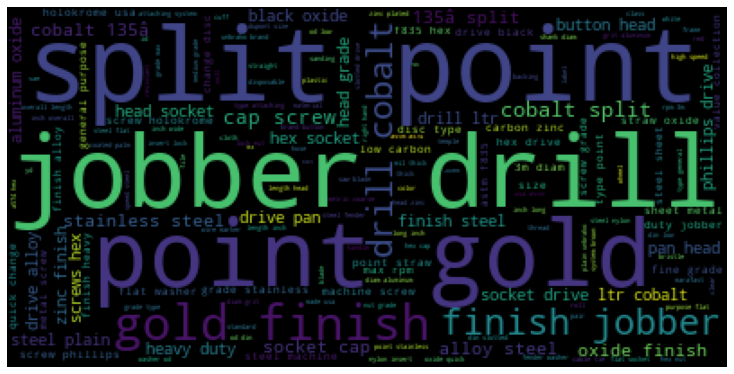

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(' '.join(df['docname']))
# plot the WordCloud image
plt.figure(figsize = (10, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [ ]:
newdf = df.docname

In [ ]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(newdf,test_size = 0.5,random_state=50) 
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (250,)
valid shape :  (250,)


In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from collections import Counter



# Open the files and get the titles
A_titles = list(train)

B_titles = list(valid)

# Will be used to check whether a match occurs multiple times, thereby indicating a missing title in B, i.e., a multiplication in A
best_matches_t = list()

# For each title in A, find the closest match in B
for A_t in A_titles:
    A_t = A_t.strip()
    max_simil = 0
    max_match_t = ""
    for B_t in B_titles:
        B_t = B_t.strip()
        # Fuzzy matching
        simil = fuzz.token_sort_ratio(A_t, B_t)
        # Store only title in B with max. similarity
        if simil > max_simil:
            max_simil = simil
            max_match_t = B_t
    print("%i: %s | %s" % (max_simil, A_t, max_match_t))
    # Append
    best_matches_t.append(max_match_t)

top_n_most_common = 3
c = Counter(best_matches_t)
# Get the most common hits; easily identify multiplications
most_common = c.most_common(top_n_most_common)
print("\nTop %i most common matches in B: " % top_n_most_common)
print(most_common)

43: ansell size 8 12 long 20 mil unsupported latex chemical resistant gloves textured finish unlined gauntlet pinked cuff ansi cut level 0 abrasion level 3 natural fda approved | valeo size 8-9 cowhide anti-vibration impact protection work gloves general purpose use uncoated unlined hook & loop cuff fingerless black pair
52: connection end cap 1 5 8-in. x 1 5 8-in. channel 3 4-in. conduit material: steel. finish: zinc plated. | value collection 1 4 screw 1 4 id 1-1 2 od 0.049 thick fender flat washer steel zinc-plated finish
91: 1 4 x 2.000 od low carbon zinc finish steel fender washer | 1 4 x 1.500 od low carbon zinc finish steel fender washer
78: 5 16 -18 grade 5 zinc finish ne steel nylon insert lock nut | 3 8 -16 grade 18-8 ne stainless steel nylon insert lock nut
96: 3 8 -16 x 1-1 4 grade 316 stainless steel hex cap screw | 3 8 -16 x 1-1 2 grade 316 stainless steel hex cap screw
68: frostbite safety glasses - scratch resistant : clear lens blue frame temple color polycarbonate sma